In [1]:
#Test notebook for tracking rigid body  marker consisting of multiple fiducials within a CT scan volume

#3D data processing
import open3d as o3d
import ct_tracking_library # our helper functions
import SimpleITK as sitk
import numpy as np
import matplotlib.pyplot as plt
import os
from ipywidgets import interact, fixed

#our processing code
from ct_tracking_library.ct_motor_functions import *
from ct_tracking_library.ct_tracking_functions import *
from ct_tracking_library.ct_processing_functions import *
from ct_tracking_library.ct_display_functions import *
from ct_tracking_library.ct_object_classes import *
from ct_tracking_library.ct_fk_functions import *

#used for GUI
%matplotlib notebook

#find transform
import datetime
import time
import pickle
from spatialmath import *
from roboticstoolbox import ET as E
import transforms3d as t3d

In [2]:
def DICOM_series_dropdown_callback(series_to_load, series_dictionary):
    """
    This function is a helper function that helps the drop dwon list for DICOM file in folder:

    Args:
        series_to_load(list): list of the DICOM serial number in the folder.
        series_dictionary(dict): dict that holds the dicm files.

    """
    global selected_series
               # Print some information about the series from the meta-data dictionary
               # DICOM standard part 6, Data Dictionary: http://medical.nema.org/medical/dicom/current/output/pdf/part06.pdf
    file_reader.SetFileName(series_dictionary[series_to_load][0])
    file_reader.ReadImageInformation()
    tags_to_print = {'0010|0010': 'Patient name: ', 
                     '0008|0060' : 'Modality: ',
                     '0008|0021' : 'Series date: ',
                     '0008|0080' : 'Institution name: ',
                     '0008|1050' : 'Performing physician\'s name: '}
    for tag in tags_to_print:
        try:
            print(tags_to_print[tag] + file_reader.GetMetaData(tag))
        except: # Ignore if the tag isn't in the dictionary
            pass
    selected_series = series_to_load

In [3]:
def get_marker(selected_series,time,v = False, debug = False):
    """
    This function finds the marker from the user sleceted dicom file:

    Args:
        selected_series(string): the serial key for the slected DICOM.
        time(Time): time intial when the function is called.
        v(bool): to show visualization for the marker
        debug(bool): wheather or not the user want to see debug info.

    Returns:
        M_list[0](Marker): the moveing marker object finded
        M_list[1](Marker): the fixed marker object finded
        v_mesh(Open3d mesh): the mesh used for finding the marker in form of open3d

    """
    M_list = []
    data_directory = "./test_data/DICOM"
    file_reader = sitk.ImageFileReader()
    series_file_names = {}
    series_IDs = list(sitk.ImageSeriesReader_GetGDCMSeriesIDs(data_directory))
    if series_IDs:
        for series in series_IDs:
            series_file_names[series] = sitk.ImageSeriesReader_GetGDCMSeriesFileNames(data_directory, series)
    for S in range(2):
        # pick marker
        if S == 0:
            target_marker_name = 'moving_marker_1_DoF'
            marker = np.array([[-10,-5,0],[-10,5,0],[0,-5,0],[10,0,0]])
            R = np.eye(3)
            crop_z = None
        else:
            target_marker_name = 'fixed_marker_1_DoF'
            marker = np.array([[0,-14,0],[0,-6,0],[0,16,0],[17,0,0]])
            R = np.eye(3)
            crop_z = [160,254]

        #convert scan to mesh for finding markers via thresholding
        scan_file = series_file_names[selected_series]
        convert_scan_to_mha(scan_file, crop_z = crop_z)
        convert_mha_to_mesh(output_mesh_file = 'temp_mesh.obj')

        #find candidate fiducials within the scanner returning clustered centroids that could be rigid body markers
        _, marker_centroid_coordinates, pcd_selected, marker_mesh, _, good_centroid_clusters = find_candidate_centroids(marker = marker, debug=debug)
        if debug:
            print('marker centroid coordinates from design: {}'.format(marker))
            print('found centroid coordinates: {}'.format(marker_centroid_coordinates))

        #display candidate fiducials
        if v:
            o3d.visualization.draw_geometries([pcd_selected, marker_mesh])

        #find best transform and marker from candidate fiducials
        tracked_R, tracked_t, permuted_centroids, min_error = find_best_transform_from_candidate_marker_clusters(marker, good_centroid_clusters)

        #get rid of column of ones to make 3xN
        permuted_centroids = permuted_centroids[:3,:].T

        #transform marker geometry coordinates using found transform to tracked image coordinates
        transformed_marker = (tracked_R @ marker.T + tracked_t).T
        error = permuted_centroids-transformed_marker
        
        #tracking error from final transform
        np.set_printoptions(2)
        print("Error (mm): {}".format(error))
        print("Error norm (mm): {}".format(np.linalg.norm(error)**0.5))
        if v:
            #create o3d visualizations
            marker_3d_tracked = create_marker_visualization(fiducial_coordinates=permuted_centroids, color=[0.8, 0.2, 0.2])
            marker_3d_base = create_marker_visualization(marker, [0.2, 0.8, 0.2])
            marker_3d_base.append(create_coordinate_frame_visualization())
            marker_3d_transformed = create_marker_visualization(marker, [0.2, 0.2, 0.8], tracked_R, tracked_t)
            marker_3d_transformed.append(create_coordinate_frame_visualization(tracked_R, tracked_t))
            #visualize tracked markers on top of mesh used for tracking
            visualization_list2 = marker_3d_tracked+marker_3d_base+marker_3d_transformed + [marker_mesh]
            visualization_list1 = copy.deepcopy(visualization_list2)
            o3d.visualization.draw_geometries(visualization_list2)
        if S == 0:
            v_mesh= marker_mesh
        #append marker
        M_list.append(Marker(name=target_marker_name,d_key=selected_series,time =time,geometry=marker,T=t2T(tracked_R, tracked_t/1000),error=error**0.5))
        
    return M_list[0],M_list[1],v_mesh

In [4]:
def calc_DLS_controller_step(J, e, alpha = 0.1, lambd = 0.01):
    '''
    calculates new position step using dls jacobian
    inputs: 
            J: [6xN] numpy array where N is the number of robot joints being controlled
            e: [6x1] numpy array for position and orientation errors stacked
            alpha: gain constant for position step
            lambd: damping constant for inverse
    return: 
        joint position setpoint delta
    '''
    J_inv = np.linalg.inv(J.T@J + lambd * np.eye(J.shape[1])) @ J.T
    return alpha * J_inv @ e

In [5]:
def close_loop(m1,m2,r):
    fk,r_error,p_error = find_fk(marker1,marker2,r)
    q_current = r.joint_postion
    J = np.array([[0,0,1,0,0,0]]).T
    e[:3] = p_error
    e[3:] = r_error
    delta_q = calc_DLS_controller_step(J, e)
    print('Joint step calculated: {}'.format(delta_q))
    q_new = q_current + delta_q
    return q_new

## Feltch the DICOM file from server
### Goto the website:  http://unicorn2.ucsd.edu:8080/dcm4chee-arc/ui2/#/study/patient
### Selected Series on the top tabs
### On the left hand side input: DIMITRI07041995 as the Patient ID
### In the middle section select Newest Frist in the Order by Tab
### In the middle section select DCM4CHEE in the Web App Service Tab and CLICK Sumbit
### Download the 1st row by clicking the 3 dots symbol and downolad it
### Once Downloaded, extract the DICOM files ONLY to the following folder: ./test_data/DICOM

In [6]:
c = moteus.Controller() # created moteus motor object
#d1,d2 = await stopping_acc_test(c,2)
d1 = .2
d2 = .2

In [11]:
#SETUP DATA DIRECTORIES FOR THE TEST DAY
data = {}
s_num = 0
ip = await motor_zero(c,stop_torque=.1,v=1)

begin zeroing
state info:  1/{MODE(0x000): 0, POSITION(0x001): 21.799041748046875, VELOCITY(0x002): -0.009439175948500633, TORQUE(0x003): 0.0, VOLTAGE(0x00d): 23.5, TEMPERATURE(0x00e): 25.0, FAULT(0x00f): 0}
Position: 21.799041748046875
Torque: 0.0

motor is ready
Initial Starting Degree:  -919.70


In [10]:
data_directory = "./test_data/DICOM"
# Global variable 'selected_series' is updated by the interact function
selected_series = ''
file_reader = sitk.ImageFileReader()    
# Directory contains multiple DICOM studies/series, store
# in dictionary with key being the series ID
series_file_names = {}
series_IDs = sitk.ImageSeriesReader_GetGDCMSeriesIDs(data_directory)
            # Check that we have at least one series
if series_IDs:
    for series in series_IDs:
        series_file_names[series] = sitk.ImageSeriesReader_GetGDCMSeriesFileNames(data_directory, series)
    
    interact(DICOM_series_dropdown_callback, series_to_load=list(series_IDs), series_dictionary=fixed(series_file_names)); 
else:
    print('Data directory does not contain any DICOM series.')

interactive(children=(Dropdown(description='series_to_load', options=('1.2.840.113619.2.416.148220411494716321…

In [12]:
u_list = [0,25,50,75]
key_list = ['1.2.840.113619.2.416.305176222189676249242208949616555819108','1.2.840.113619.2.416.217188650113553336717059945783907503594','1.2.840.113619.2.416.199955979763917726194490236240131480202','1.2.840.113619.2.416.227879804124450913909460899233029279524']
ratio = 0.5040628051757813 #converting mm to rev
for x in range(len(u_list)):
    print("Moveing to ", u_list[x])
    if u_list[x] == 0:
        currcent_p_list,p_mm = await one_axis_farward(c,ip,user_desried=0)
        zero_mm = p_mm
    else:
        if u_list[x] >= u_list[x-1]:
            currcent_p_list,p_mm = await one_axis_farward(c,ip,user_desried=u_list[x]*ratio)
        else:
            currcent_p_list,p_mm = await one_axis_backward(c,ip,user_desried=u_list[x]*ratio)
    #3. process selected CT scan into two marker objects and print reprojection tracking error and warning if high
    #selected_series = key_list[x]
    selected_keys = input('Enter DICOM key: ')
    time = datetime.datetime.now()
    time = time.strftime("%m/%d/%y %I:%M%p")
    marker1,marker2,mesh = get_marker(selected_keys,time)
    robot = Robot(time=time,m=ratio,joint_postion=p_mm,set_point=u_list[x],d1=d1,d2=d2,zero=zero_mm)
    #5. calculate forward kinematics of joint position and error between and FK and tracking
    fk,r_error,p_error = find_fk(marker1,marker2,robot)
    #6. display forward kinematics transforms + tracked marker transforms in open3D AND print errors with warnings
    display_fk(fk,marker1,mesh)
    #7. save everything to data directory w/ timestamp for this loop IF good for this loop to dictionary
    append_value(data, "scan"+str(s_num), marker1)
    append_value(data, "scan"+str(s_num), marker2)
    append_value(data, "scan"+str(s_num), robot)
    #8. save to temporary pickle file for this test every loop incase the software crashes
    d_name = 'temp_data'+str(s_num)+'.pkl'
    with open(d_name, 'wb') as f:
        pickle.dump(data, f)
    s_num += 1
#8. save to pickle file for final test data
with open('data.pkl', 'wb') as f:
    pickle.dump(data, f)

Moveing to  0
Target postion:  -16.051788330078125
Begain Testing
Finish
Enter DICOM key1.2.840.113619.2.416.305176222189676249242208949616555819108
spacing:  [0.63 0.7  0.7 ]
 origin:  [-149.69 -180.   -180.  ]
[Open3D INFO] Skipping non-triangle primitive geometry of type: 1
[Open3D INFO] Skipping non-triangle primitive geometry of type: 2
[Open3D DEBUG] [ClusterConnectedTriangles] Compute triangle adjacency
[Open3D DEBUG] [ClusterConnectedTriangles] Done computing triangle adjacency
[Open3D DEBUG] [ClusterConnectedTriangles] Done clustering, #clusters=37
[Open3D DEBUG] Precompute Neighbours
[Open3D DEBUG] Done Precompute Neighbours
[Open3D DEBUG] Compute Clusters
[Open3D DEBUG] Done Compute Clusters: 8


100%|███████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 143.45it/s]
C:\Users\derek\AppData\Local\Temp\ipykernel_18604\1555513766.py:81: RuntimeWarning: invalid value encountered in sqrt
  M_list.append(Marker(name=target_marker_name,d_key=selected_series,time =time,geometry=marker,T=t2T(tracked_R, tracked_t/1000),error=error**0.5))


[Open3D DEBUG] Precompute Neighbours
[Open3D DEBUG] Done Precompute Neighbours
[Open3D DEBUG] Compute Clusters
[Open3D DEBUG] Done Compute Clusters: 2
point cloud has 2 clusters
[0 1 2 3]
[4 5 6 7]
[5.91 0.06]
Everything looks good!
the final error is:  0.05748629483237988
Error (mm): [[ 0.04 -0.03  0.02]
 [-0.06 -0.02 -0.  ]
 [ 0.05  0.   -0.02]
 [-0.02  0.05  0.01]]
Error norm (mm): 0.3390760824133129
spacing:  [0.63 0.7  0.7 ]
 origin:  [ -49.69 -180.   -180.  ]
[Open3D INFO] Skipping non-triangle primitive geometry of type: 1
[Open3D INFO] Skipping non-triangle primitive geometry of type: 2
[Open3D DEBUG] [ClusterConnectedTriangles] Compute triangle adjacency
[Open3D DEBUG] [ClusterConnectedTriangles] Done computing triangle adjacency
[Open3D DEBUG] [ClusterConnectedTriangles] Done clustering, #clusters=38
[Open3D DEBUG] Precompute Neighbours
[Open3D DEBUG] Done Precompute Neighbours
[Open3D DEBUG] Compute Clusters
[Open3D DEBUG] Done Compute Clusters: 8


100%|███████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 123.41it/s]


[Open3D DEBUG] Precompute Neighbours
[Open3D DEBUG] Done Precompute Neighbours
[Open3D DEBUG] Compute Clusters
[Open3D DEBUG] Done Compute Clusters: 2
point cloud has 2 clusters
[0 1 2 3]
[4 5 6 7]
[0.15 5.8 ]
Everything looks good!
the final error is:  0.1530577086188559
Error (mm): [[-0.09 -0.15  0.01]
 [ 0.13 -0.04 -0.03]
 [-0.04  0.2  -0.01]
 [ 0.   -0.01  0.03]]
Error norm (mm): 0.5532769805781836
Postion Error norm(m):  0.00795143062813141
Rotional Error norm(Euler Angle):  [ 2.19e-19 -3.58e-03 -7.70e-04]
Moveing to  25
Target postion:  -3.4502182006835938
Begain Testing
Finish
Enter DICOM key1.2.840.113619.2.416.217188650113553336717059945783907503594
spacing:  [0.63 0.7  0.7 ]
 origin:  [-149.69 -180.   -180.  ]
[Open3D INFO] Skipping non-triangle primitive geometry of type: 1
[Open3D INFO] Skipping non-triangle primitive geometry of type: 2
[Open3D DEBUG] [ClusterConnectedTriangles] Compute triangle adjacency
[Open3D DEBUG] [ClusterConnectedTriangles] Done computing triangle a

100%|███████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 160.01it/s]


[Open3D DEBUG] Precompute Neighbours
[Open3D DEBUG] Done Precompute Neighbours
[Open3D DEBUG] Compute Clusters
[Open3D DEBUG] Done Compute Clusters: 2
point cloud has 2 clusters
[0 1 6 7]
[2 3 4 5]
[0.05 5.91]
Everything looks good!
the final error is:  0.04597412046734961
Error (mm): [[ 0.03 -0.01  0.01]
 [-0.05 -0.02 -0.  ]
 [ 0.04 -0.01 -0.01]
 [-0.02  0.04  0.01]]
Error norm (mm): 0.3032296834656845
spacing:  [0.63 0.7  0.7 ]
 origin:  [ -49.69 -180.   -180.  ]
[Open3D INFO] Skipping non-triangle primitive geometry of type: 1
[Open3D INFO] Skipping non-triangle primitive geometry of type: 2
[Open3D DEBUG] [ClusterConnectedTriangles] Compute triangle adjacency
[Open3D DEBUG] [ClusterConnectedTriangles] Done computing triangle adjacency
[Open3D DEBUG] [ClusterConnectedTriangles] Done clustering, #clusters=33
[Open3D DEBUG] Precompute Neighbours
[Open3D DEBUG] Done Precompute Neighbours
[Open3D DEBUG] Compute Clusters
[Open3D DEBUG] Done Compute Clusters: 7


100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 224.04it/s]


[Open3D DEBUG] Precompute Neighbours
[Open3D DEBUG] Done Precompute Neighbours
[Open3D DEBUG] Compute Clusters
[Open3D DEBUG] Done Compute Clusters: 2
point cloud has 2 clusters
[0 5 6]
[1 2 3 4]
[0.15]
Everything looks good!
the final error is:  0.15252497903498627
Error (mm): [[-0.09 -0.14  0.02]
 [ 0.13 -0.04 -0.03]
 [-0.04  0.2  -0.01]
 [ 0.   -0.01  0.03]]
Error norm (mm): 0.5523132789187424
Postion Error norm(m):  0.010123654110573664
Rotional Error norm(Euler Angle):  [ 2.38e-19 -3.88e-03 -1.70e-03]
Moveing to  50
Target postion:  9.151351928710938
Begain Testing
Finish
Enter DICOM key1.2.840.113619.2.416.199955979763917726194490236240131480202
spacing:  [0.63 0.7  0.7 ]
 origin:  [-149.69 -180.   -180.  ]
[Open3D INFO] Skipping non-triangle primitive geometry of type: 2
[Open3D DEBUG] [ClusterConnectedTriangles] Compute triangle adjacency
[Open3D DEBUG] [ClusterConnectedTriangles] Done computing triangle adjacency
[Open3D DEBUG] [ClusterConnectedTriangles] Done clustering, #clu

100%|███████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 129.32it/s]

[Open3D DEBUG] Precompute Neighbours
[Open3D DEBUG] Done Precompute Neighbours
[Open3D DEBUG] Compute Clusters
[Open3D DEBUG] Done Compute Clusters: 2
point cloud has 2 clusters
[0 1 2 3]
[4 5 6 7]
[0.05 5.92]
Everything looks good!
the final error is:  0.047542641380929014
Error (mm): [[ 0.04 -0.01  0.01]
 [-0.06 -0.02 -0.  ]
 [ 0.04 -0.01 -0.01]
 [-0.02  0.03  0.01]]
Error norm (mm): 0.3083590160216789


spacing:  [0.63 0.7  0.7 ]
 origin:  [ -49.69 -180.   -180.  ]
[Open3D INFO] Skipping non-triangle primitive geometry of type: 2
[Open3D DEBUG] [ClusterConnectedTriangles] Compute triangle adjacency
[Open3D DEBUG] [ClusterConnectedTriangles] Done computing triangle adjacency
[Open3D DEBUG] [ClusterConnectedTriangles] Done clustering, #clusters=9
[Open3D DEBUG] Precompute Neighbours
[Open3D DEBUG] Done Precompute Neighbours
[Open3D DEBUG] Compute Clusters
[Open3D DEBUG] Done Compute Clusters: 8


100%|███████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 137.71it/s]

[Open3D DEBUG] Precompute Neighbours
[Open3D DEBUG] Done Precompute Neighbours
[Open3D DEBUG] Compute Clusters
[Open3D DEBUG] Done Compute Clusters: 2
point cloud has 2 clusters
[0 1 2 3]
[4 5 6 7]
[5.8  0.16]
Everything looks good!
the final error is:  0.1611293279259281
Error (mm): [[-0.1  -0.15  0.01]
 [ 0.15 -0.05 -0.03]
 [-0.04  0.21 -0.01]
 [ 0.   -0.    0.03]]
Error norm (mm): 0.5676783031364298


Postion Error norm(m):  0.009733694092946766
Rotional Error norm(Euler Angle):  [ 2.75e-19 -4.49e-03 -2.48e-04]
Moveing to  75
Target postion:  21.75292205810547
Begain Testing
Finish
Enter DICOM key1.2.840.113619.2.416.227879804124450913909460899233029279524
spacing:  [0.63 0.7  0.7 ]
 origin:  [-149.69 -180.   -180.  ]
[Open3D INFO] Skipping non-triangle primitive geometry of type: 1
[Open3D INFO] Skipping non-triangle primitive geometry of type: 2
[Open3D DEBUG] [ClusterConnectedTriangles] Compute triangle adjacency
[Open3D DEBUG] [ClusterConnectedTriangles] Done computing triangle adjacency
[Open3D DEBUG] [ClusterConnectedTriangles] Done clustering, #clusters=9
[Open3D DEBUG] Precompute Neighbours
[Open3D DEBUG] Done Precompute Neighbours
[Open3D DEBUG] Compute Clusters
[Open3D DEBUG] Done Compute Clusters: 8


100%|███████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 158.13it/s]

[Open3D DEBUG] Precompute Neighbours
[Open3D DEBUG] Done Precompute Neighbours
[Open3D DEBUG] Compute Clusters
[Open3D DEBUG] Done Compute Clusters: 2
point cloud has 2 clusters
[0 1 2 3]
[4 5 6 7]
[0.05 5.92]
Everything looks good!
the final error is:  0.05086182350221248
Error (mm): [[ 0.04 -0.01  0.01]
 [-0.06 -0.02 -0.  ]
 [ 0.04 -0.01 -0.02]
 [-0.02  0.03  0.01]]
Error norm (mm): 0.3189414476113523


spacing:  [0.63 0.7  0.7 ]
 origin:  [ -49.69 -180.   -180.  ]
[Open3D INFO] Skipping non-triangle primitive geometry of type: 1
[Open3D INFO] Skipping non-triangle primitive geometry of type: 2
[Open3D DEBUG] [ClusterConnectedTriangles] Compute triangle adjacency
[Open3D DEBUG] [ClusterConnectedTriangles] Done computing triangle adjacency
[Open3D DEBUG] [ClusterConnectedTriangles] Done clustering, #clusters=8
[Open3D DEBUG] Precompute Neighbours
[Open3D DEBUG] Done Precompute Neighbours
[Open3D DEBUG] Compute Clusters
[Open3D DEBUG] Done Compute Clusters: 7


100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 146.02it/s]

[Open3D DEBUG] Precompute Neighbours
[Open3D DEBUG] Done Precompute Neighbours
[Open3D DEBUG] Compute Clusters
[Open3D DEBUG] Done Compute Clusters: 2
point cloud has 2 clusters
[0 1 2]
[3 4 5 6]
[0.16]
Everything looks good!
the final error is:  0.1617649635954966
Error (mm): [[-0.1  -0.15  0.01]
 [ 0.15 -0.05 -0.03]
 [-0.04  0.21 -0.01]
 [ 0.   -0.01  0.03]]
Error norm (mm): 0.5687969120793407
Postion Error norm(m):  0.009464784029016187
Rotional Error norm(Euler Angle):  [ 2.12e-19 -3.45e-03 -2.82e-05]


In [13]:
await read_p()

Begain Testing
Position(rev): 21.727127075195312
Position in Degree:  1244.87


43.104007778591075

In [14]:
for w in data:
    print(data[w][2])
    print("set point: ",data[w][2].set_point)
    print("joint postion: ",data[w][2].joint_postion)
    print("joint postion - zero postion: ",data[w][2].joint_postion - data[w][2].zero_postion)

Robot(08/31/22 06:11PM)
set point:  0
joint postion:  -31.568317256085045
joint postion - zero postion:  0.0
Robot(08/31/22 06:11PM)
set point:  25
joint postion:  -6.839232966017704
joint postion - zero postion:  24.72908429006734
Robot(08/31/22 06:12PM)
set point:  50
joint postion:  18.169409576603197
joint postion - zero postion:  49.73772683268824
Robot(08/31/22 06:12PM)
set point:  75
joint postion:  43.168607379127
joint postion - zero postion:  74.73692463521205


In [15]:
P_norm_list = []
P_list = []
P_std = []
f1_error = []
f2_error = []
with open('data.pkl', 'rb') as f:
    data_load = pickle.load(f)

In [16]:
for x in data_load:
    f1_error.append(data_load[x][0].error)
    f2_error.append(data_load[x][1].error)
    _,_,p_error = find_fk(data_load[x][0],data_load[x][1],data_load[x][2])
    P_std.append(np.std(p_error*1000))
    P_norm_list.append(np.linalg.norm(p_error*1000))
    P_list.append(p_error*1000)

Postion Error norm(m):  0.00795143062813141
Rotional Error norm(Euler Angle):  [ 2.19e-19 -3.58e-03 -7.70e-04]
Postion Error norm(m):  0.010123654110573664
Rotional Error norm(Euler Angle):  [ 2.38e-19 -3.88e-03 -1.70e-03]
Postion Error norm(m):  0.009733694092946766
Rotional Error norm(Euler Angle):  [ 2.75e-19 -4.49e-03 -2.48e-04]
Postion Error norm(m):  0.009464784029016187
Rotional Error norm(Euler Angle):  [ 2.12e-19 -3.45e-03 -2.82e-05]


<IPython.core.display.Javascript object>


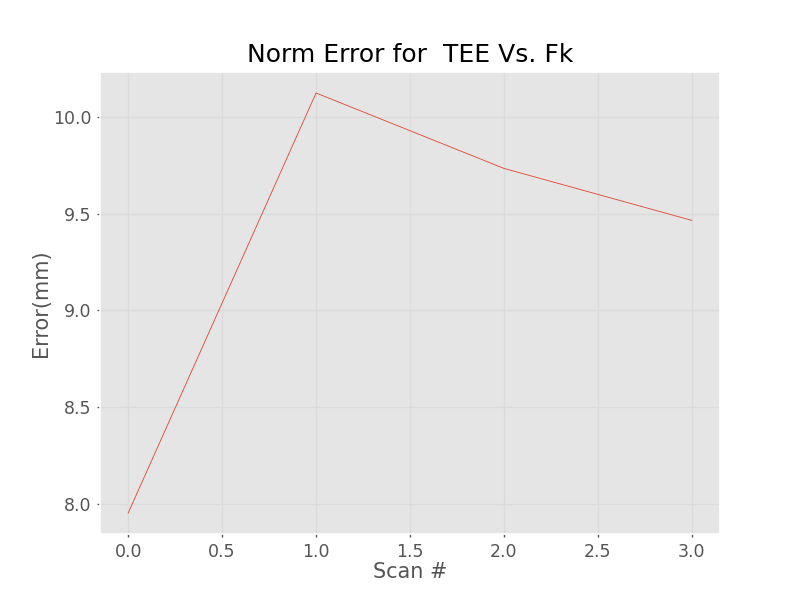

<IPython.core.display.Javascript object>


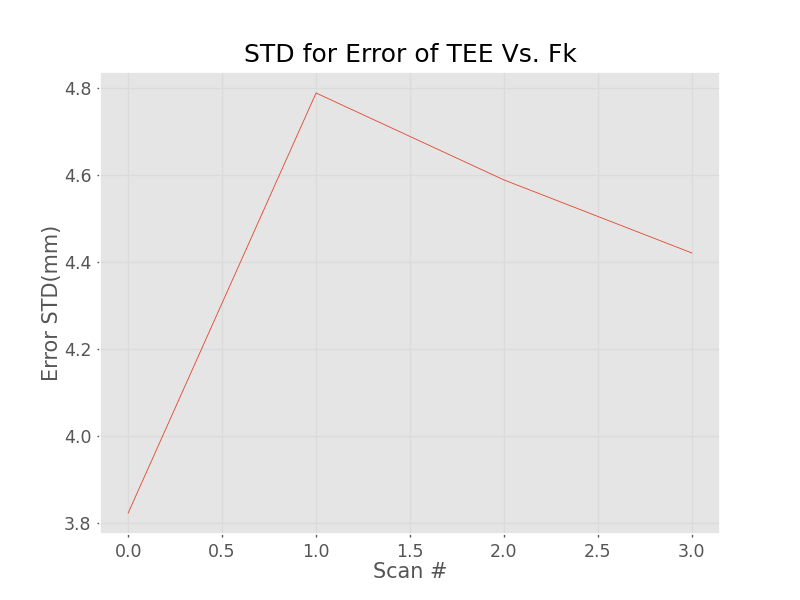

<IPython.core.display.Javascript object>


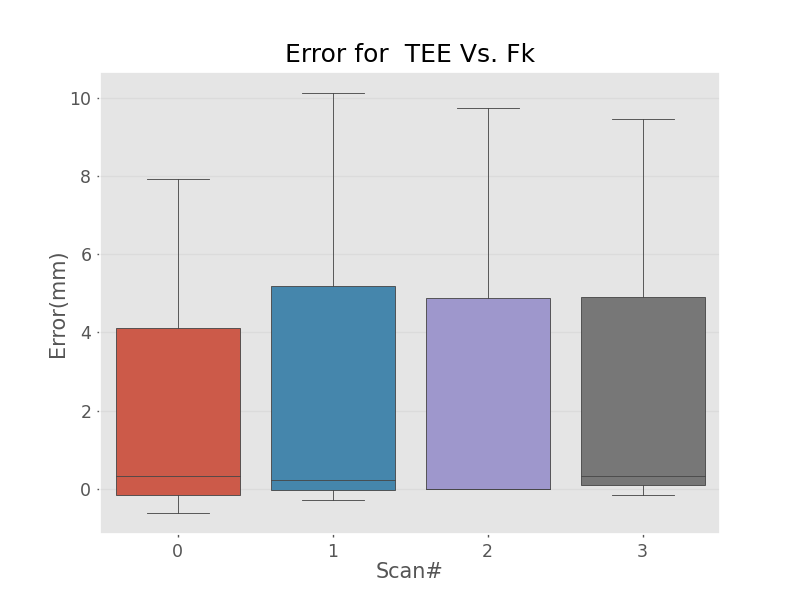

[Text(0.5, 1.0, 'Error for  TEE Vs. Fk'),
 Text(0, 0.5, 'Error(mm)'),
 Text(0.5, 0, 'Scan#')]

In [17]:
plt.plot(P_norm_list)
plt.title("Norm Error for  TEE Vs. Fk")
plt.ylabel("Error(mm)")
plt.xlabel("Scan #")
plt.figure()
plt.plot(P_std)
plt.title("STD for Error of TEE Vs. Fk")
plt.ylabel("Error STD(mm)")
plt.xlabel("Scan #")
plt.figure()
sns.boxplot(data=P_list,  orient='v').set(title='Error for  TEE Vs. Fk',ylabel="Error(mm)",xlabel="Scan#")